## Industrial Textile Dataset
En este dataset tenemos fotos tomadas con 10 cámaras diferentes a diferentes telas. De cada cámara tenemos una parte de las fotos para train, en las que solamente hay fotos de telas en buen estado. Y otra parte para test, en las que hay fotos de telas en buen estado y dañadas.

El procedimiento que seguiremos es el siguiente:

1. Aprendizaje supervisado
    - Leeremos todos los datos juntos (train y test) y particionaremos en train y test, teniendo así ejemplos de anomalías en los datos de train también.
2. Aprendizaje no supervisado
    - Usaremos los datos como vienen, entrenando al modelo solo con las fotos de train (tela en buen estado).

### 1. Aprendizaje supervisado
Leemos todos los datos juntos:

In [3]:
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def cargar_dataset_imagenes_raw(root_path, image_size=(64, 64)):
    """
    Leemos las imágenes y las devolvemos en formato (N, Alto, Ancho)
    con valores 0-255 (Enteros). 
    """
    X_list = []
    y_list = []
    
    root = Path(root_path)
    print(f"Escaneando imágenes en: {root.absolute()} ...")
    
    if not root.exists():
        print("Error: La ruta no existe.")
        return np.array([]), np.array([])

    contador = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
            
        # Etiquetamos las imágenes, si vienen de una carpeta anomaly serán 1, si no serán 0 (good)
        label = 1 if 'anomaly' in str(img_path).lower() else 0
            
        # Leemos la imagen en escala de grises
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # Redimensionamos la imagen
        img = cv2.resize(img, image_size)
        
        X_list.append(img)
        y_list.append(label)
        contador += 1

    X_array = np.array(X_list)
    y_array = np.array(y_list)

    print(f"Carga completa. {contador} imágenes procesadas.")
    return X_array, y_array

# Ejecución

ruta = "./ITD"
X_total, y_total = cargar_dataset_imagenes_raw(ruta, image_size=(64, 64))

# 
print(f"\nForma de X_total: {X_total.shape}")
print(f"Tipo de dato: {X_total.dtype}") # Debería decir 'uint8'
print(f"Max valor pixel: {X_total.max()}") # Debería ser 255

# Particionamos en train, val y test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_total, y_total, test_size=0.3, random_state=42, stratify=y_total
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("-" * 30)
print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")
print("-" * 30)

print(f"Train anomalies: {np.sum(y_train)}")
print(f"Val anomalies:   {np.sum(y_val)}")
print(f"Test anomalies:  {np.sum(y_test)}")

Escaneando imágenes en: /workspace/OneDrive - UPNA/4º/Extracción del conocimiento/TrabajoGrupo/ITD ...
Carga completa. 5878 imágenes procesadas.

Forma de X_total: (5878, 64, 64)
Tipo de dato: uint8
Max valor pixel: 255
------------------------------
Train shape: (4114, 64, 64)
Val shape:   (882, 64, 64)
Test shape:  (882, 64, 64)
------------------------------
Train anomalies: 675
Val anomalies:   145
Test anomalies:  145


#### Extracción de Características 

Aplicamos técnicas de ingeniería de características para extraer información relevante:

1.  **LBP (Local Binary Patterns):** Codifica la textura local comparando cada píxel con sus vecinos.
    * *Visualización:* Convertimos la imagen en un mapa de texturas y luego calculamos su histograma (frecuencia de patrones).
2.  **HOG (Histogram of Oriented Gradients):** Captura la forma y los bordes mediante la orientación de los gradientes de intensidad.
    * *Visualización:* Muestra las direcciones predominantes de los bordes en cada celda de la imagen.

A continuación, visualizaremos cómo estas técnicas transforman una imagen original antes de procesar todo el dataset.

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 2

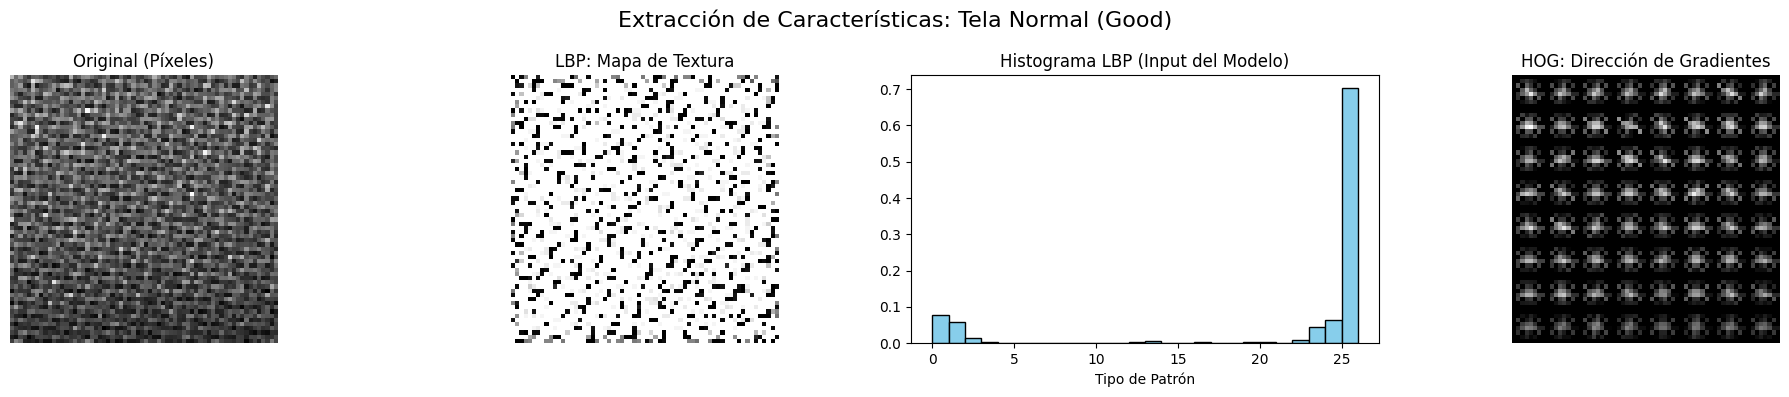

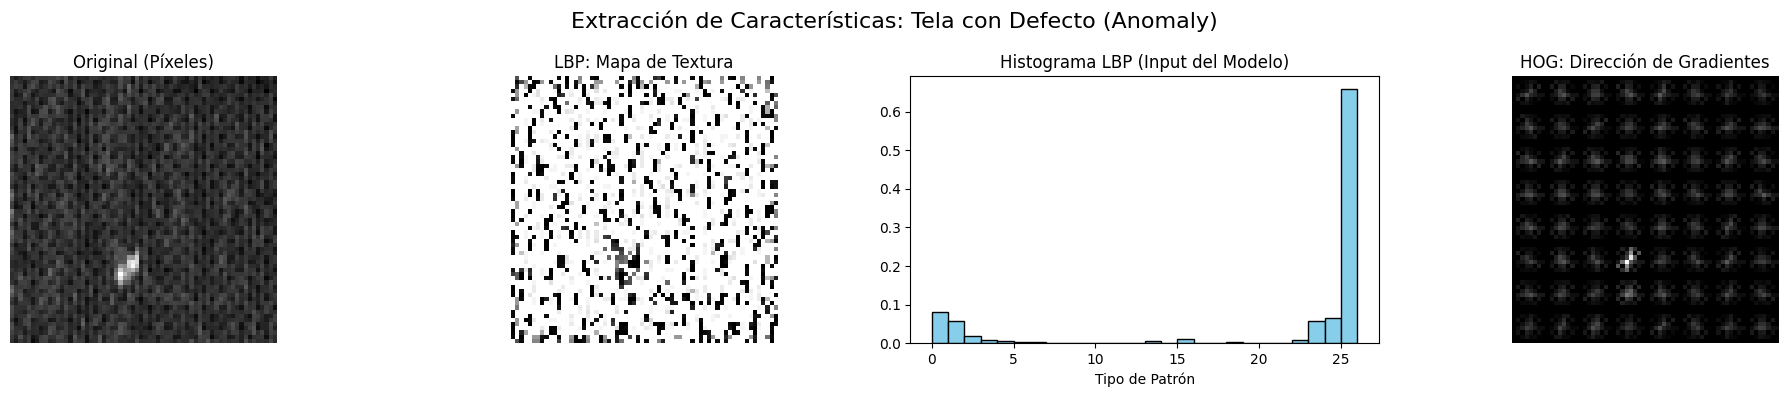

In [4]:
import sys
!{sys.executable} -m pip install seaborn -q
!{sys.executable} -m pip install scikit-image seaborn -q
import seaborn as sns
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. FUNCIÓN DE VISUALIZACIÓN (Para el informe) ---
def visualizar_features(imagen, titulo="Ejemplo"):
    """
    Muestra la imagen original, su transformación LBP (y histograma) 
    y su visualización HOG.
    """
    # Parámetros
    radius = 3
    n_points = 8 * radius
    
    # 1. Calculamos LBP
    lbp = local_binary_pattern(imagen, n_points, radius, method='uniform')
    
    # 2. Calculamos HOG (y la imagen para visualizar)
    fd, hog_image = hog(imagen, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # --- PLOT ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f"Extracción de Características: {titulo}", fontsize=16)

    # A. Original
    axes[0].imshow(imagen, cmap='gray')
    axes[0].set_title("Original (Píxeles)")
    axes[0].axis('off')

    # B. LBP Imagen (Mapa de Textura)
    axes[1].imshow(lbp, cmap='gray')
    axes[1].set_title("LBP: Mapa de Textura")
    axes[1].axis('off')

    # C. Histograma LBP (Lo que realmente ve el modelo)
    # n_points + 2 es el número de bins para método 'uniform'
    n_bins = int(lbp.max() + 1)
    axes[2].hist(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True, color='skyblue', edgecolor='black')
    axes[2].set_title("Histograma LBP (Input del Modelo)")
    axes[2].set_xlabel("Tipo de Patrón")
    
    # D. HOG Visualización
    axes[3].imshow(hog_image, cmap='gray')
    axes[3].set_title("HOG: Dirección de Gradientes")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# --- MOSTRAR UN EJEMPLO DE "GOOD" Y UNO DE "ANOMALY" ---
# --- SELECCIÓN INTELIGENTE DE EJEMPLOS ---

# 1. Ejemplo GOOD: Cogemos el primero, suelen estar bien
idx_good = np.where(y_train == 0)[0][0]

# 2. Ejemplo ANOMALY: Buscamos uno que se vea bien (no sea negro)
indices_anomalias = np.where(y_train == 1)[0]
idx_bad = -1

for idx in indices_anomalias:
    # Calculamos el brillo medio. Si es > 50, asumimos que se ve algo.
    if np.mean(X_train[idx]) > 50: 
        idx_bad = idx
        break

# Comprobación de seguridad
if idx_bad == -1:
    print("No se encontró ninguna anomalía con suficiente brillo. Cogemos la primera aunque sea oscura.")
    idx_bad = indices_anomalias[0]

print(f"Indices seleccionados -> Good: {idx_good}, Anomaly: {idx_bad}")

# --- VISUALIZAR ---
visualizar_features(X_train[idx_good], titulo="Tela Normal (Good)")
visualizar_features(X_train[idx_bad], titulo="Tela con Defecto (Anomaly)")

Antes de pasar al entrenamiento de los modelos, podemos hacer algunas hipótesis basándonos en estas visualizaciones:

1.  LBP:
    Al comparar los histogramas LBP de la tela *Good* y la tela *Anomaly*, observamos que son prácticamente idénticos.
    Esto puede ser porque el defecto ocupa una porción muy pequeña de la imagen, y por eso su impacto en un histograma global se diluye. Esto sugiere que es probable que los modelos tengan dificultades para separar las clases basándose únicamente en la frecuencia de texturas (LBP), ya que lo que aporta al histograma la anomalía es muy poco frente a la textura dominante del tejido.

2.  HOG:
    A diferencia del LBP, en la visualización de HOG sí se aprecia una perturbación local clara en la dirección de los gradientes justo en la zona del defecto. Esto puede ayudar a los modelos a detectar la diferencia entre una tela normal y una anómala.


Para entrenar modelos, creamos conjuntos de train, val y test con las características:

In [ ]:
radius = 3
n_points = 8 * radius
n_bins_lbp = int(n_points + 2) 


def extraer_solo_lbp(imagenes):
    features = []
    for img in imagenes:
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins_lbp, range=(0, n_bins_lbp), density=True)
        features.append(hist)
    return np.array(features)

def extraer_solo_hog(imagenes):
    features = []
    for img in imagenes:
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, feature_vector=True)
        features.append(fd)
    return np.array(features)


print("PROCESANDO DATASET LBP")
X_train_lbp = extraer_solo_lbp(X_train)
X_val_lbp   = extraer_solo_lbp(X_val)
X_test_lbp  = extraer_solo_lbp(X_test)

print("\n PROCESANDO DATASET HOG")
X_train_hog = extraer_solo_hog(X_train)
X_val_hog   = extraer_solo_hog(X_val)
X_test_hog  = extraer_solo_hog(X_test)

print("\n PROCESANDO DATASET LBP+HOG")

X_train_mix = np.hstack((X_train_lbp, X_train_hog))
X_val_mix   = np.hstack((X_val_lbp,   X_val_hog))
X_test_mix  = np.hstack((X_test_lbp,  X_test_hog))


print(f"\n Datos LBP: {X_train_lbp.shape[1]} características por foto")
print(f"\n Datos HOG:   {X_train_hog.shape[1]} características por foto")
print(f"\n Datos LBP + HOG:   {X_train_mix.shape[1]} características por foto")

In [ ]:
# los diferentes datasets que vamos a usar para entrenar, para ver cuál va mejor
datasets = {
    #Para usarlos en estos modelos, los pasamos de (N,64,64) a aplanados
    "Normal": (
        X_train.reshape(len(X_train), -1), 
        X_val.reshape(len(X_val), -1), 
        X_test.reshape(len(X_test), -1)
    ),
    
    "LBP": (X_train_lbp, X_val_lbp, X_test_lbp),
    "HOG": (X_train_hog, X_val_hog, X_test_hog),
    "LBP + HOG": (X_train_mix, X_val_mix, X_test_mix)
}

### Isolation forest

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report
import pandas as pd

def grid_search_iso_forest(nombre_dataset, X_tr, X_v, y_v):
    print(f"Usando el dataset: {nombre_dataset}...")
    
    # Rejilla de parámetros
    param_grid = {
        'contamination': [0.01, 0.03, 0.05, 0.1, 0.15], # % estimado de anomalías
        'n_estimators': [100, 200],
        'max_features': [1.0, 0.8] # % de características a usar
    }
    
    best_score = 0
    best_params = {}
    best_model = None
    
    # Bucle manual (Train en Train -> Eval en Val)
    for cont in param_grid['contamination']:
        for n_est in param_grid['n_estimators']:
            for max_feat in param_grid['max_features']:
                
                # Entrenar (No Supervisado, solo X_tr)
                clf = IsolationForest(contamination=cont, n_estimators=n_est, 
                                      max_features=max_feat, random_state=42, n_jobs=-1)
                clf.fit(X_tr)
                
                # Evaluar en Validación
                preds_raw = clf.predict(X_v)
                # Convertir: -1 (Anomalía) -> 1, 1 (Normal) -> 0
                preds_map = [1 if x == -1 else 0 for x in preds_raw]
                
                # Usamos F1 porque el Recall solo puede ser engañoso si marca todo como error
                score = f1_score(y_v, preds_map, pos_label=1)
                
                if score > best_score:
                    best_score = score
                    best_params = {'contamination': cont, 'n_estimators': n_est, 'max_features': max_feat}
                    best_model = clf
    
    print(f"Mejor F1 en Val: {best_score:.2%} | Params: {best_params}")
    return best_model, best_params

# --- EJECUCIÓN MASIVA ISO FOREST ---
resultados_iso = {}

for nombre, (X_tr, X_v, X_te) in datasets.items():
    # Grid Search
    best_model, params = grid_search_iso_forest(nombre, X_tr, X_v, y_val)
    
    # Evaluación Final en TEST con el ganador
    preds_test_raw = best_model.predict(X_te)
    preds_test = [1 if x == -1 else 0 for x in preds_test_raw]
    
    # Guardamos métricas
    recall = recall_score(y_test, preds_test, pos_label=1)
    f1 = f1_score(y_test, preds_test, pos_label=1)
    cm = confusion_matrix(y_test, preds_test)
    
    resultados_iso[nombre] = {'Recall': recall, 'F1': f1, 'CM': cm, 'Params': params}
    print(f"En TEST -> Recall: {recall:.2%} | F1: {f1:.2%}\n")

Usando el dataset: Normal...
Mejor F1 en Val: 10.64% | Params: {'contamination': 0.15, 'n_estimators': 200, 'max_features': 0.8}
En TEST -> Recall: 11.03% | F1: 11.07%

Usando el dataset: LBP...
Mejor F1 en Val: 49.76% | Params: {'contamination': 0.1, 'n_estimators': 200, 'max_features': 1.0}
En TEST -> Recall: 52.41% | F1: 64.68%

Usando el dataset: HOG...
Mejor F1 en Val: 41.45% | Params: {'contamination': 0.15, 'n_estimators': 200, 'max_features': 1.0}
En TEST -> Recall: 46.21% | F1: 49.08%

Usando el dataset: LBP + HOG...
Mejor F1 en Val: 41.45% | Params: {'contamination': 0.15, 'n_estimators': 200, 'max_features': 1.0}
En TEST -> Recall: 47.59% | F1: 49.29%



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit

def grid_search_random_forest(nombre_dataset, X_tr, y_tr, X_v, y_v):
    print(f"Usando el dataset: {nombre_dataset}...")
    
    # 1. Unir Train y Val para el GridSearch (necesario para sklearn)
    # Pero usamos 'test_fold' para decirle qué parte es Val
    X_completo = np.vstack((X_tr, X_v))
    y_completo = np.hstack((y_tr, y_v))
    
    # Indices: -1 para Train (no validar), 0 para Val (validar)
    test_fold = [-1]*len(X_tr) + [0]*len(X_v)
    ps = PredefinedSplit(test_fold)
    
    # 2. Rejilla
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 20],
        'class_weight': ['balanced', {0:1, 1:10}] # Importante probar pesos agresivos
    }
    
    # 3. Grid Search optimizando RECALL
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        scoring='recall', # Priorizamos encontrar defectos
        cv=ps,            # Usamos nuestra partición fija
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_completo, y_completo)
    
    print(f" Mejor Recall en Val: {grid.best_score_:.2%} | Params: {grid.best_params_}")
    return grid.best_estimator_

# --- EJECUCIÓN MASIVA RANDOM FOREST ---
resultados_rf = {}

print("\n--- INICIANDO GRID SEARCH: RANDOM FOREST ---")
for nombre, (X_tr, X_v, X_te) in datasets.items():
    
    # Grid Search
    best_rf = grid_search_random_forest(nombre, X_tr, y_train, X_v, y_val)
    
    # Evaluación Final en TEST
    preds_test = best_rf.predict(X_te)
    
    recall = recall_score(y_test, preds_test, pos_label=1)
    f1 = f1_score(y_test, preds_test, pos_label=1)
    cm = confusion_matrix(y_test, preds_test)
    
    resultados_rf[nombre] = {'Recall': recall, 'F1': f1, 'CM': cm, 'Params': best_rf.get_params()}
    print(f"Resultado TEST -> Recall: {recall:.2%} | F1: {f1:.2%}\n")


--- INICIANDO GRID SEARCH: RANDOM FOREST ---
Usando el dataset: Normal...
 Mejor Recall en Val: 48.28% | Params: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}
Resultado TEST -> Recall: 57.24% | F1: 72.17%

Usando el dataset: LBP...
 Mejor Recall en Val: 45.52% | Params: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}
Resultado TEST -> Recall: 57.24% | F1: 72.17%

Usando el dataset: HOG...
 Mejor Recall en Val: 28.97% | Params: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}
Resultado TEST -> Recall: 40.00% | F1: 56.86%

Usando el dataset: LBP + HOG...
 Mejor Recall en Val: 29.66% | Params: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Resultado TEST -> Recall: 40.00% | F1: 56.86%



In [17]:
print("\n" + "="*60)
print(f"{'DATASET':<20} | {'MODELO':<15} | {'RECALL (TEST)':<15} | {'F1 (TEST)':<15}")
print("="*60)

for nombre in datasets.keys():
    # Iso Forest
    rec_iso = resultados_iso[nombre]['Recall']
    f1_iso = resultados_iso[nombre]['F1']
    print(f"{nombre:<20} | IsoForest       | {rec_iso:.2%}          | {f1_iso:.2%}")
    
    # Random Forest
    rec_rf = resultados_rf[nombre]['Recall']
    f1_rf = resultados_rf[nombre]['F1']
    print(f"{nombre:<20} | Random Forest   | {rec_rf:.2%}          | {f1_rf:.2%}")
    print("-" * 60)


DATASET              | MODELO          | RECALL (TEST)   | F1 (TEST)      
Normal               | IsoForest       | 11.03%          | 11.07%
Normal               | Random Forest   | 57.24%          | 72.17%
------------------------------------------------------------
LBP                  | IsoForest       | 52.41%          | 64.68%
LBP                  | Random Forest   | 57.24%          | 72.17%
------------------------------------------------------------
HOG                  | IsoForest       | 46.21%          | 49.08%
HOG                  | Random Forest   | 40.00%          | 56.86%
------------------------------------------------------------
LBP + HOG            | IsoForest       | 47.59%          | 49.29%
LBP + HOG            | Random Forest   | 40.00%          | 56.86%
------------------------------------------------------------


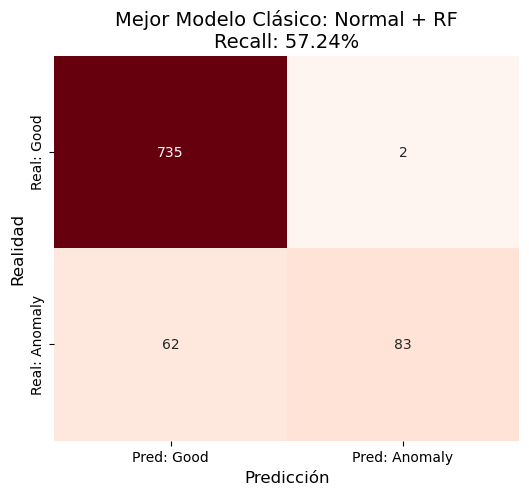

De 145 telas defectuosas reales, el modelo ha dejado escapar 62.


In [18]:
# vamos a mostrar la matriz de confusión del mejor
best_recall = -1
best_name = ""
best_cm = None

for nombre, metricas in resultados_rf.items():
    if metricas['Recall'] > best_recall:
        best_recall = metricas['Recall']
        best_name = nombre
        best_cm = metricas['CM']

plt.figure(figsize=(6, 5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])

plt.title(f'Mejor Modelo Clásico: {best_name} + RF\nRecall: {best_recall:.2%}', fontsize=14)
plt.ylabel('Realidad', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.show()

fallos = best_cm[1, 0] 
total_anomalias = best_cm[1, 0] + best_cm[1, 1]

print(f"De {total_anomalias} telas defectuosas reales, el modelo ha dejado escapar {fallos}.")

In [ ]:
#
#
#
#
#
#
#                   OC SVM
#
#
#
#
#

Los resultados muestran las limitaciones de estas técnicas para este problema:


El enfoque de extracción de características + clasificador clásico es insuficiente. Para mejorar el Recall, necesitamos un modelos más complejos.

Vamos a pasar a usar CNNs porque son capaces de aprender filtros espaciales y nos puede ayudar a detectar las pequeñas anomalías de las telas.

Usamos Transfer Learning utilizando una arquitectura ResNet18, y sustituimos únicamente la capa final (fully connected) para adaptarla a nuestro problema binario (Good vs Anomaly).
Como el dataset tiene muchas más muestras Good que Anomaly, calculamos pesos para la función de pérdida con el fin de penalizar más los errores en la clase de las anomalías.

Dispositivo seleccionado: cuda
Pesos de clase calculados -> Good: 1.0 | Anomaly: 5.09
Cargando arquitectura ResNet18 pre-entrenada...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 19.4MB/s]


Iniciando entrenamiento por 10 épocas...
Epoch [1/10] | Train Loss: 0.4028 | Val Loss: 0.2980
Epoch [2/10] | Train Loss: 0.2898 | Val Loss: 0.2544
Epoch [3/10] | Train Loss: 0.2394 | Val Loss: 0.2367
Epoch [4/10] | Train Loss: 0.2078 | Val Loss: 0.2301
Epoch [5/10] | Train Loss: 0.2017 | Val Loss: 0.2374
Epoch [6/10] | Train Loss: 0.1847 | Val Loss: 0.2162
Epoch [7/10] | Train Loss: 0.1781 | Val Loss: 0.2907
Epoch [8/10] | Train Loss: 0.2061 | Val Loss: 0.2768
Epoch [9/10] | Train Loss: 0.2001 | Val Loss: 0.2441
Epoch [10/10] | Train Loss: 0.2021 | Val Loss: 0.2938

Evaluando rendimiento en el conjunto de Test...


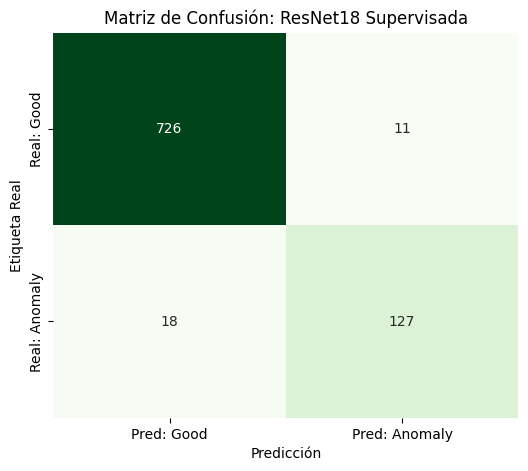

              precision    recall  f1-score   support

        Good       0.98      0.99      0.98       737
     Anomaly       0.92      0.88      0.90       145

    accuracy                           0.97       882
   macro avg       0.95      0.93      0.94       882
weighted avg       0.97      0.97      0.97       882

Resumen de detección:
- Anomalías totales: 145
- Anomalías detectadas: 127
- Falsos Negativos (Escapados): 18
- Tasa de Recall: 87.59%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")

class TextileDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        
        # Hacemos que tenga 3 canales por si no los tiene
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
            img = np.repeat(img, 3, axis=2)
        
        # Cambiamos al formato de pytorch
        img = img.transpose((2, 0, 1))
        
        # Normalizamos 
        img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return img_tensor, label_tensor

train_dataset = TextileDataset(X_train, y_train)
val_dataset   = TextileDataset(X_val, y_val)
test_dataset  = TextileDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Calculamos un peso para penalizar más los errores en la clase minoritaria (Anomaly)
num_good = np.sum(y_train == 0)
num_anomaly = np.sum(y_train == 1)

# Evitamos división por cero si no hubiera anomalías en train
weight_anomaly = num_good / num_anomaly if num_anomaly > 0 else 1.0
print(f"Pesos de clase calculados -> Good: 1.0 | Anomaly: {weight_anomaly:.2f}")

class_weights = torch.tensor([1.0, weight_anomaly], dtype=torch.float32).to(device)

# Configuramos el transfer learning
print("Cargando arquitectura ResNet18 pre-entrenada...")
model = models.resnet18(pretrained=True)

# Congelamos los pesos de las capas convolucionales
# Con esto aprovechamos las características aprendidas en ImageNet sin modificarlas
for param in model.parameters():
    param.requires_grad = False

# Reemplazamos la capa final (Fully Connected)
# Adaptamos la salida a nuestro problema de 2 clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
# Solo optimizamos los parámetros de la capa final (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10 
train_losses = []
val_losses = []

print(f"Iniciando entrenamiento por {num_epochs} épocas...")

for epoch in range(num_epochs):
   
    model.train() 
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()        
        outputs = model(inputs)        
        loss = criterion(outputs, labels) 
        loss.backward()               
        optimizer.step()             
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validación
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Evaluación Final 
print("\nEvaluando rendimiento en el conjunto de Test...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Obtenemos la clase con mayor probabilidad
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Visualización de resultados
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.title('Matriz de Confusión: ResNet18 Supervisada')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

print(classification_report(all_labels, all_preds, target_names=['Good', 'Anomaly']))

fallos = cm[1,0]
total_anom = cm[1,0] + cm[1,1]
recall = cm[1,1] / total_anom
print(f"Resumen de detección:")
print(f"- Anomalías totales: {total_anom}")
print(f"- Anomalías detectadas: {cm[1,1]}")
print(f"- Falsos Negativos (Escapados): {fallos}")
print(f"- Tasa de Recall: {recall:.2%}")

Con este modelo mejoramos mucho el resultado, ahora vamos a pasar con la siguiente fase de aprendizaje no supervisado

### 2. Aprendizaje no supervisado
Leemos los datos por separado, como vienen en las carpetas:

In [8]:
def cargar_datos_separados_raw(root_path, image_size=(64, 64)):
    """
    Recorre las carpetas originales manteniendo la separación entre 'train' y 'test'.
    Devuelve los arrays de imágenes en formato crudo (0-255) para ahorrar memoria
    hasta el momento del procesamiento.
    """
    # Inicializamos las listas para separar los datos
    # X_train solo contendrá imágenes de la carpeta 'train' (presumiblemente buenas)
    X_train = []
    y_train = [] 
    
    # X_test contendrá imágenes de la carpeta 'test' (mezcla de buenas y anomalías)
    X_test = []
    y_test = []
    
    root = Path(root_path)
    print(f"Iniciando lectura de imágenes en: {root.absolute()}")
    
    if not root.exists():
        print("Error: La ruta especificada no existe.")
        return np.array([]), np.array([]), np.array([]), np.array([])

    count_train = 0
    count_test = 0
    
    # Recorremos recursivamente todos los archivos
    for img_path in root.rglob('*.*'):
        # Filtramos para asegurarnos de que solo procesamos imágenes válidas
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
        
        path_str = str(img_path).lower()
        
        # 1. Determinamos el conjunto (Split)
        # La lógica se basa en el nombre de la carpeta padre
        if 'train' in path_str:
            is_train = True
        elif 'test' in path_str:
            is_train = False
        else:
            # Si el archivo no está en una carpeta train o test, lo ignoramos
            continue
            
        # 2. Asignación de etiqueta (Label)
        # Buscamos la palabra clave 'anomaly' en la ruta. 
        # 1 = Defecto, 0 = Buen estado
        label = 1 if 'anomaly' in path_str else 0
        
        # 3. Lectura de la imagen
        # Leemos en escala de grises para reducir dimensionalidad (1 canal)
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        # Redimensionamos al tamaño estándar definido (ej. 64x64)
        img = cv2.resize(img, image_size)
        
        # Nota: No normalizamos aquí (mantenemos uint8 0-255) para optimizar 
        # el uso de memoria RAM antes de entrar al modelo.
        
        # 4. Agregamos a la lista correspondiente
        if is_train:
            X_train.append(img)
            y_train.append(label)
            count_train += 1
        else:
            X_test.append(img)
            y_test.append(label)
            count_test += 1

    # Convertimos listas a arrays de Numpy para vectorización
    X_train_arr = np.array(X_train)
    y_train_arr = np.array(y_train)
    X_test_arr = np.array(X_test)
    y_test_arr = np.array(y_test)

    print("Proceso finalizado.")
    print(f"- Imágenes en Train: {count_train}")
    print(f"- Imágenes en Test:  {count_test}")
    
    return X_train_arr, y_train_arr, X_test_arr, y_test_arr

In [9]:
ruta = "./ITD"
print("Cargando datos especificos para el Autoencoder...")
X_train_2, y_train_2, X_test_2, y_test_2 = cargar_datos_separados_raw(ruta, image_size=(64, 64))

# Verificacion de dimensiones para asegurar que todo ha ido bien
print(f"Dimensiones de X_train_2: {X_train_2.shape}")


Cargando datos especificos para el Autoencoder...
Iniciando lectura de imágenes en: /workspace/OneDrive - UPNA/4º/Extracción del conocimiento/TrabajoGrupo/ITD
Proceso finalizado.
- Imágenes en Train: 4391
- Imágenes en Test:  1141
Dimensiones de X_train_2: (4391, 64, 64)


Primero probaremos con DBSCAN:

#
#
#
#
#
#
#                   DBSCAN
#
#
#
#
#

Vamos a probar con un Autoencoder

In [10]:
class TextileDatasetAE_2(Dataset):
    """
    Dataset personalizado para el Autoencoder.
    Se encarga de la normalizacion y la adaptacion de canales al vuelo.
    """
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx]
        
        # Expansion de dimensiones: (H, W) -> (H, W, 1) -> (H, W, 3)
        # Aunque trabajamos en grises, usamos 3 canales para compatibilidad
        # si quisieramos usar modelos pre-entrenados o visualizaciones estandar RGB.
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
            img = np.repeat(img, 3, axis=2)
            
        # Transposicion a formato "Channel First" que requiere PyTorch: (C, H, W)
        img = img.transpose((2, 0, 1))
        
        # Normalizacion min-max para llevar los pixeles al rango [0, 1]
        # Esto es crucial para la convergencia con la funcion de activacion Sigmoid.
        img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0
        
        return img_tensor


In [11]:
dataset_train_ae_2 = TextileDatasetAE_2(X_train_2)
loader_train_ae_2 = DataLoader(dataset_train_ae_2, batch_size=32, shuffle=True)

dataset_test_ae_2 = TextileDatasetAE_2(X_test_2)
loader_test_ae_2 = DataLoader(dataset_test_ae_2, batch_size=1, shuffle=False)


In [14]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # --- ENCODER (Compresion) ---
        # Reduce progresivamente la dimension espacial aumentando la profundidad (features).
        # El objetivo es forzar al modelo a aprender una representacion latente compacta.
        self.encoder = nn.Sequential(
            # Bloque 1: 64x64 -> 32x32
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32), # Normalizacion por lotes para estabilizar el entrenamiento
            nn.ReLU(),
            
            # Bloque 2: 32x32 -> 16x16
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Bloque 3: 16x16 -> 8x8
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Bloque 4 (Latent Space): 8x8 -> 4x4
            # Aqui es donde la informacion esta mas comprimida
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # --- DECODER (Reconstruccion) ---
        # Realiza el proceso inverso usando convoluciones transpuestas (Upsampling).
        self.decoder = nn.Sequential(
            # Bloque 1: 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Bloque 2: 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Bloque 3: 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Bloque 4 (Salida): 32x32 -> 64x64
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            # Usamos Sigmoid para asegurar que la salida este en el rango [0, 1]
            # coincidiendo con los datos de entrada normalizados.
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstructed = self.decoder(latent_code)
        return reconstructed


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ae_2 = ConvAutoencoder().to(device)

criterion_2 = nn.MSELoss()

# AdamW mejor que Adam estandar porque tiene el weight decay desacoplado
optimizer_2 = optim.AdamW(model_ae_2.parameters(), lr=0.001, weight_decay=0.0001)

num_epochs = 15

print("Iniciando entrenamiento del Autoencoder...")

for epoch in range(num_epochs):
    model_ae_2.train() # Modo entrenamiento (activa BatchNorm)
    running_loss = 0.0
    
    for img in loader_train_ae_2:
        img = img.to(device)
        
        # 1. Forward Pass
        # La entrada y el objetivo son la misma imagen (aprendizaje no supervisado)
        output = model_ae_2(img)
        
        # 2. Calculo del error
        loss = criterion_2(output, img)
        
        # 3. Backward Pass y Optimizacion
        optimizer_2.zero_grad() # Limpieza de gradientes anteriores
        loss.backward()         # Calculo de gradientes actuales
        optimizer_2.step()      # Actualizacion de pesos
        
        running_loss += loss.item()
    
    # Promedio del error en la epoca
    avg_loss = running_loss / len(loader_train_ae_2)
    print(f"Epoca {epoch+1}/{num_epochs} | Error de reconstruccion (MSE): {avg_loss:.6f}")

print("Entrenamiento completado exitosamente.")

Iniciando entrenamiento del Autoencoder...
Epoca 1/15 | Error de reconstruccion (MSE): 0.013945
Epoca 2/15 | Error de reconstruccion (MSE): 0.004532
Epoca 3/15 | Error de reconstruccion (MSE): 0.003165
Epoca 4/15 | Error de reconstruccion (MSE): 0.002710
Epoca 5/15 | Error de reconstruccion (MSE): 0.002498
Epoca 6/15 | Error de reconstruccion (MSE): 0.002565
Epoca 7/15 | Error de reconstruccion (MSE): 0.002346
Epoca 8/15 | Error de reconstruccion (MSE): 0.002220
Epoca 9/15 | Error de reconstruccion (MSE): 0.002132
Epoca 10/15 | Error de reconstruccion (MSE): 0.002217
Epoca 11/15 | Error de reconstruccion (MSE): 0.002228
Epoca 12/15 | Error de reconstruccion (MSE): 0.002161
Epoca 13/15 | Error de reconstruccion (MSE): 0.002060
Epoca 14/15 | Error de reconstruccion (MSE): 0.002015
Epoca 15/15 | Error de reconstruccion (MSE): 0.001988
Entrenamiento completado exitosamente.


Evaluando el conjunto de test para calcular errores de reconstrucción...
Umbral de corte óptimo calculado: 0.001029


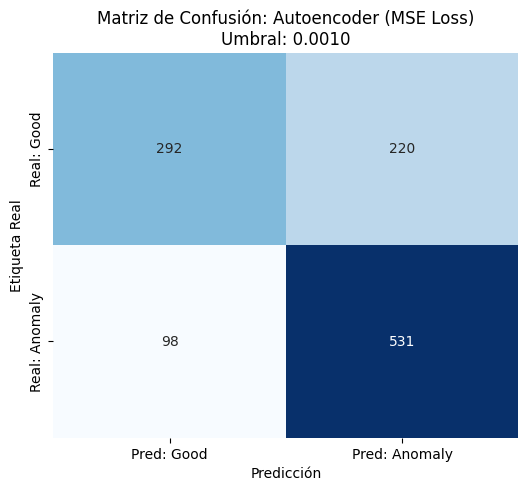

Informe de Clasificación:
              precision    recall  f1-score   support

        Good       0.75      0.57      0.65       512
     Anomaly       0.71      0.84      0.77       629

    accuracy                           0.72      1141
   macro avg       0.73      0.71      0.71      1141
weighted avg       0.73      0.72      0.71      1141

Resumen de rendimiento:
- Total de muestras defectuosas: 629
- Defectos detectados correctamente: 531
- Falsos Negativos (Defectos escapados): 98
- Recall (Sensibilidad): 84.42%


In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve

model_ae_2.eval()

# Lista para almacenar el error de reconstrucción (MSE) de cada imagen
reconstruction_errors_2 = []

# Iteramos sobre el conjunto de test.
# Dejamos el loader_test_ae_2 en shuffle=False para que
# los índices coincidan con las etiquetas reales de y_test_2.
print("Evaluando el conjunto de test para calcular errores de reconstrucción...")

with torch.no_grad():
    for img in loader_test_ae_2:
        img = img.to(device)
        
        # 1. Reconstrucción de la imagen
        reconstruction = model_ae_2(img)
        
        # 2. Cálculo del error (Score de Anomalía)
        # Calculamos el MSE por imagen. Si el error es alto, significa que
        # el modelo no pudo reconstruir bien la entrada (posible anomalía).
        loss = criterion_2(reconstruction, img)
        reconstruction_errors_2.append(loss.item())

# Elección del umbral óptimo
# Como el Autoencoder devuelve un valor continuo (error) y no una clase,
# necesitamos encontrar el punto de corte (umbral) que mejor separa
# las clases Good (0) y Anomaly (1).

# Calculamos la Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_2, reconstruction_errors_2)

# Índice de Youden: Buscamos el punto que maximiza la diferencia (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_2 = thresholds[optimal_idx]

print(f"Umbral de corte óptimo calculado: {optimal_threshold_2:.6f}")


predictions_2 = [1 if error > optimal_threshold_2 else 0 for error in reconstruction_errors_2]

# Creación de la Matriz de Confusión
cm_2 = confusion_matrix(y_test_2, predictions_2)

# Visualización
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.title(f'Matriz de Confusión: Autoencoder (MSE Loss)\nUmbral: {optimal_threshold_2:.4f}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

print("Informe de Clasificación:")
print(classification_report(y_test_2, predictions_2, target_names=['Good', 'Anomaly']))

total_anomalies = cm_2[1, 0] + cm_2[1, 1]
detected_anomalies = cm_2[1, 1]
missed_anomalies = cm_2[1, 0]
recall_score = detected_anomalies / total_anomalies

print("Resumen de rendimiento:")
print(f"- Total de muestras defectuosas: {total_anomalies}")
print(f"- Defectos detectados correctamente: {detected_anomalies}")
print(f"- Falsos Negativos (Defectos escapados): {missed_anomalies}")
print(f"- Recall (Sensibilidad): {recall_score:.2%}")

Hemos conseguido mejorar un poco más el rendimiento.


Pero queríamos mejorar aún más, por eso usamosotra vez como en aprendizaje supervisado el transfer learning, la ResNet 18. Aunque esta vez usamos menos capas y solo la usamos para extraer características, no para clasificar.

**Funcionamiento:**
1.  Banco de Memoria: Extrae los vectores de características de todas las imágenes normales y los almacena en un banco de memoria, donde tendrá todo telas buenas (las almacena por parches).
2.  Inferencia: Al recibir una imagen nueva, extrae sus características y busca, para cada parche, cuál es su vecino más cercano en el banco de memoria utilizando el algoritmo KNN.
3.  Detección:La puntuación de anomalía de la imagen se define por la distancia del parche más lejano a la memoria. Si un parche de la imagen de test no se parece a ninguno visto en el entrenamiento (del banco de memoria), la distancia será alta y se marcará como anomalía.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iniciando extracción de características del conjunto de Train...


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 173.36it/s]


Banco de memoria generado. Dimensiones totales: (6998, 256)
Ajustando algoritmo Nearest Neighbors...
Evaluando conjunto de Test...


100%|██████████████████████████████████████████████████████████████████████████████| 1141/1141 [00:06<00:00, 175.81it/s]


Umbral de decisión óptimo calculado: 1.3552


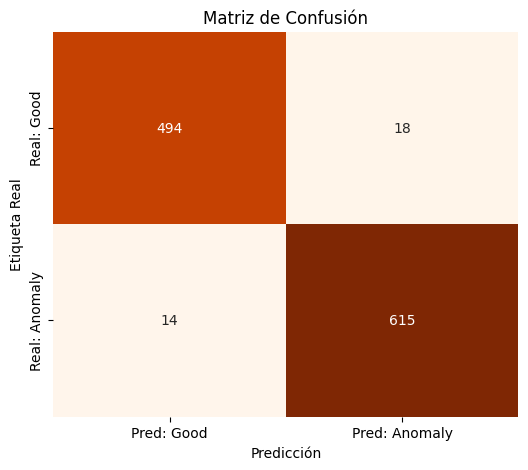

              precision    recall  f1-score   support

        Good       0.97      0.96      0.97       512
     Anomaly       0.97      0.98      0.97       629

    accuracy                           0.97      1141
   macro avg       0.97      0.97      0.97      1141
weighted avg       0.97      0.97      0.97      1141

Recall obtenido con PatchCore: 97.77%


In [15]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Utilizamos la ResNet18 de ant4es
        backbone = models.resnet18(pretrained=True)
        
        # Eliminamos las capas finales, no solo la última como antes
        # Nos quedamos con las capas hasta la layer3 
        self.features = nn.Sequential(*list(backbone.children())[:-3])
        
        self.eval() 
        
    def forward(self, x):
        with torch.no_grad():
            return self.features(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = FeatureExtractor().to(device)

# CREAMOS EL BANCO DE MEMORIA
# En esta fase no entrenamos pesos, sino que 'memorizamos' las características normales.
memory_bank = []
print("Iniciando extracción de características del conjunto de Train...")

# Porcentaje de submuestreo para que lo podamos ejecutar
subsample_ratio = 0.1 

for batch in tqdm(loader_train_ae_2):
    # Por si veine con o sin etiquetas
    if isinstance(batch, list) or isinstance(batch, tuple):
        img = batch[0]
    else:
        img = batch
        
    img = img.to(device)
    
    # Extracción de mapa de características
    features = extractor(img) 
    
    # Aplanado de características espaciales
    # Transformamos (Batch, Canales, Alto, Ancho) -> (Batch * Alto * Ancho, Canales)
    # Cada vector resultante representa un parche de la imagen.
    B, C, H, W = features.shape
    features = features.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy()
    
    n_vectors = features.shape[0]
    if n_vectors > 0:
        indices = np.random.choice(n_vectors, int(n_vectors * subsample_ratio), replace=False)
        memory_bank.append(features[indices])

# Concatenamos todos los vectores en una única matriz (Banco de Memoria)
memory_bank = np.vstack(memory_bank)
print(f"Banco de memoria generado. Dimensiones totales: {memory_bank.shape}")

# KNN
print("Ajustando algoritmo Nearest Neighbors...")


knn = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean')
knn.fit(memory_bank)


print("Evaluando conjunto de Test...")
test_scores = []
test_labels_real = []

for i, batch in enumerate(tqdm(loader_test_ae_2)):
    if isinstance(batch, list) or isinstance(batch, tuple):
        img = batch[0]
    else:
        img = batch
        
    img = img.to(device)
    
    features = extractor(img)
    B, C, H, W = features.shape
    features_flat = features.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy()
    
    # Buscamos al vecino más cercano en el banco de memoria
    # Obtenemos las distancias de cada parche de la imagen nueva a lo normal
    distances, _ = knn.kneighbors(features_flat)
    
    # Calculamos el score de Anomalía
    # Tomamos la distancia max  
    # Si existe al menos un parche muy lejano al banco de memoria entonces será anomalía
    if len(distances) > 0:
        image_score = np.max(distances)
    else:
        image_score = 0
        
    test_scores.append(image_score)
    # Guardamos la etiqueta real para la validación posterior
    test_labels_real.append(y_test_2[i])


fpr, tpr, thresholds = roc_curve(test_labels_real, test_scores)
optimal_idx = np.argmax(tpr - fpr)
umbral_patchcore = thresholds[optimal_idx]

print(f"Umbral de decisión óptimo calculado: {umbral_patchcore:.4f}")

preds_patch = [1 if s > umbral_patchcore else 0 for s in test_scores]

cm = confusion_matrix(test_labels_real, preds_patch)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

print(classification_report(test_labels_real, preds_patch, target_names=['Good', 'Anomaly']))

recall = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Recall obtenido con PatchCore: {recall:.2%}")

Con PatchCore conseguimos captar casi todas las telas con fallos y clasificando muy pocas telas buenas en Anomaly